In [3]:
from torch_TICLNet import *
from torch_DatasetLoader import *
from pylab import *
from IPython.display import clear_output
%matplotlib inline

In [4]:
class TICLNet2(nn.Module):
    def __init__(self):
        super(TICLNet2, self).__init__()
        self.rnn = EventSummarizeNet()
        
        self.fc = nn.Sequential(
            nn.Linear(16,16),
            nn.ReLU(True),
            nn.Linear(16,4),
        )
        
    def forward(self, batchEvents):
        batchSummary = self.summarizeBatchEvents(batchEvents)
        output = self.fc(batchSummary)
        return output # (batch_size, nClasses=4)
        
    def summarizeBatchEvents(self, batchEvents):
        batchSummary = []
        for event in batchEvents:
            event =  torch.tensor(event,dtype=torch.float32)
            eventSummary = self.rnn(event)
            batchSummary.append(eventSummary)
        batchSummary = torch.cat(batchSummary)
        return batchSummary # (batch_size , Length=16)


class EventSummarizeNet(nn.Module):
    
    def __init__(self):
        super(EventSummarizeNet, self).__init__()
        self.input_size  = 4
        self.hidden_size = 16
        self.output_size = 16
    
        self.lstm1 = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input):
        batch_size = 1
        h_t = torch.zeros(batch_size, self.hidden_size)
        c_t = torch.zeros(batch_size, self.hidden_size) 

        for i, input_t in enumerate(input.chunk(input.size(0), dim=0)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
        
        output = torch.sigmoid(self.linear(h_t))
        return output
    


In [5]:
# load training dataset
trainset = DatasetLoader('../data/pickle/dataset_CLUSTERS_train.pkl')
# initialize a model
model = TICLNet2()

In [6]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# begin Training
for epoch in range(2):
    running_loss = 0.0
    for i, batch in enumerate(trainset.getBatches(batch_size=50)):
        # 1.get the inputs
        inputs = batch["feature"]
        labels = batch["label"]
        # 2.zero the parameter gradients
        optimizer.zero_grad()
        # 3.forward + backward + optimize
        outputs = model(inputs)
        loss    = F.cross_entropy( outputs, torch.tensor(labels) )
        loss.backward()
        optimizer.step()
        
        #### monitor running loss ####
        running_loss += loss.data
        if i % 10 == 9:
            print('[{:2d}, {:3d}] loss: {:5.3f}'.format(epoch+1, i+1, running_loss/10))
            clear_output(wait=True)
            running_loss = 0.0

[ 2, 560] loss: 0.431


In [7]:
torch.save(model.state_dict(), '../models/RNN.dict')

# Test

In [8]:
whichset = "test"
# load training dataset
testset = DatasetLoader('../data/pickle/dataset_CLUSTERS_{}.pkl'.format(whichset))
# initialize a model
model = TICLNet2()
model.load_state_dict(torch.load('../models/RNN.dict'))
model.eval()
print('model loaded for {} dataset'.format(whichset))

model loaded for test dataset


In [11]:
# calculate softmax for testing events
softmax = []
for i in range(len(testset)):
    event = testset[i]
    X = event["feature"]
    y = F.softmax(model(X),dim=1)
    softmax.append(y.data.numpy())
softmax = np.array(softmax)  
softmax = softmax.reshape(-1,4)
predicts = np.argmax(softmax,axis=1)
labels = np.array(testset.label)

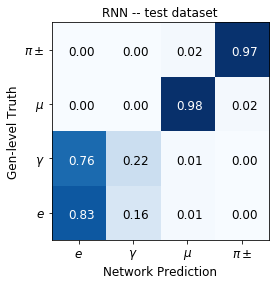

In [14]:
# a) plot confusion matrix
%matplotlib inline
h = np.histogram2d(labels,predicts,bins=np.arange(5))[0]
hnorm = h.copy()
for i in range(h.shape[0]):
    hnorm[i] /= h[i].sum()
plt.figure(facecolor='w')
plt.imshow(hnorm,origin='lower',cmap="Blues")
plt.ylabel('Gen-level Truth',fontsize=12)
plt.xlabel('Network Prediction',fontsize=12)
plt.yticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\mu$',r'$\pi\pm$'],fontsize=12)
plt.xticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\mu$',r'$\pi\pm$'],fontsize=12)


for i in range(4):
    for j in range(4):
        clr = 'k'
        val = hnorm[j,i]
        if val >0.5:
            clr = 'w'
        plt.text(i-0.2,j-0.1,'{:4.2f}'.format(val), color=clr,fontsize=12)
plt.title('RNN -- {} dataset'.format(whichset))
plt.savefig('../plots/TICLNet/{}_confusion_RNN.png'.format(whichset),dpi=200)